In [ ]:
#default_exp en_task.en_task2

In [ ]:
#export
import os

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import transformers

import Hasoc.config as config
import Hasoc.utils.utils as utils
import Hasoc.utils.engine as engine
import Hasoc.model.model as model
import Hasoc.dataset.dataset as dataset

from functools import partial
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from catalyst.data.sampler import BalanceClassSampler
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
#export
SEED = 42
utils.seed_everything(SEED)

In [ ]:
#export
df = pd.read_csv(config.DATA_PATH/'fold_df.csv')

In [ ]:
#hide
df.head(2)

,tweet_id,text,task1,task2,ID,kfold_task1,kfold_task2
0,1.126953e+18,"We need a word for ‘going somewhere alone,sitt...",NOT,NONE,hasoc_2020_en_1503,2,0
1,1.123482e+18,RT @RiverCityLabs: Come and work from our spac...,NOT,NONE,hasoc_2020_en_3570,2,0


In [ ]:
#export
le = LabelEncoder()
le.fit_transform(df.task2)
le.classes_

array(['HATE', 'NONE', 'OFFN', 'PRFN'], dtype=object)

In [ ]:
#export
df['task2_encoded'] = le.transform(df.task2.values)

In [ ]:
fold = 0
train_df = df.query(f'kfold_task2!={fold}').reset_index(drop=True)
valid_df = df.query(f'kfold_task2=={fold}').reset_index(drop=True)

In [ ]:
#export
train_ds = utils.create_loader(train_df.text.values, train_df.task2_encoded, bs=config.TRAIN_BATCH_SIZE, 
                               ret_dataset=True)
train_dl = utils.create_loader(train_df.text.values, train_df.task2_encoded, bs=config.TRAIN_BATCH_SIZE, 
                               sampler=BalanceClassSampler(labels=train_ds.get_labels(), mode="upsampling"))
valid_dl = utils.create_loader(valid_df.text.values, valid_df.task2_encoded, bs=config.VALID_BATCH_SIZE)

In [ ]:
train_dl.batch_size, valid_dl.batch_size

(16, 16)

In [ ]:
#hide
next(iter(train_dl))

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[  101,  2017,  2412,  ...,     0,     0,     0],
         [  101, 19387,  1030,  ...,     0,     0,     0],
         [  101,  1030,  4937,  ...,     0,     0,     0],
         ...,
         [  101, 19387,  1030,  ...,     0,     0,     0],
         [  101, 19387,  1030,  ...,     0,     0,     0],
         [  101, 10834,  2123,  ...,     0,     0,     0]]),
 'targets': tensor([[1, 0, 0, 0],
         [1, 0, 0, 0],
         [0, 1, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 1, 0],
         [0, 1, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 1, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0

In [ ]:
#export
modeller = model.HasocModel(len(le.classes_), drop=0.6)

In [ ]:
#export
model_params = list(modeller.named_parameters())

In [ ]:
#export
# we don't want weight decay for these
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']

optimizer_params = [
    {'params': [p for n, p in model_params if n not in no_decay], 
    'weight_decay':0.001},
    #  no weight decay should be applied
    {'params': [p for n, p in model_params if n in no_decay],
    'weight_decay':0.0}
]

In [ ]:
#export
# lr = config.LR
lr = 1e-4

In [ ]:
#export
optimizer = AdamW(optimizer_params, lr=lr)

In [ ]:
#export
num_train_steps = int(len(df) / config.TRAIN_BATCH_SIZE * config.NUM_EPOCHS)

In [ ]:
num_train_steps

927

In [ ]:
#export
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, 
                                                num_warmup_steps=20, 
                                                num_training_steps=num_train_steps-20)

In [ ]:
#export
fit = engine.BertFitter(modeller, (train_dl, valid_dl), optimizer, nn.CrossEntropyLoss(), partial(f1_score, average='macro'), config.DEVICE, scheduler=scheduler, log_file='en_task2_log.txt')

epoch,train_loss,valid_loss,metric,time
1,0.697543,0.811020,0.537472,0:0:59
2,0.124921,1.081368,0.588989,0:0:58
3,0.039473,1.153476,0.581708,0:0:58
4,0.038103,1.155010,0.581553,0:0:58
5,0.037241,1.155043,0.581550,0:0:58
6,0.038430,1.155044,0.581550,0:0:58


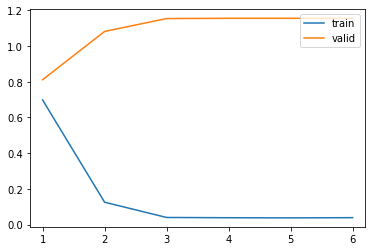

In [ ]:
#export
NUM_EPOCHS = 6
fit.fit(NUM_EPOCHS, model_path=os.path.join(config.MODEL_PATH/'en_task2.pth'))

## inference

In [ ]:
#export
test_df = pd.read_csv(config.DATA_PATH/'en_task_a/english_test.csv')

In [ ]:
#hide
test_df.head()

,tweet_id,text,task1,task2,ID
0,1130081762154090497,RT @delmiyaa: Samini resetting the show and mo...,NOT,NONE,hasoc_2020_en_2713
1,1130048316807491584,@Swxnsea how do you know that he’s left?,HOF,NONE,hasoc_2020_en_3874
2,1123657766143504386,Tried to get Divock Origi on a free seeing as ...,NOT,NONE,hasoc_2020_en_281
3,1126782963042013186,RT @nutclusteruwu: that....is yalls stupid whi...,HOF,PRFN,hasoc_2020_en_2026
4,1130159113529434113,&amp; IT DID. But a bitch got big girls things...,HOF,PRFN,hasoc_2020_en_4023


In [ ]:
#export
test_dl = utils.create_loader(test_df.text.values, lbls=[None]*len(test_df.text.values), bs=config.VALID_BATCH_SIZE, is_test=True)

In [ ]:
#export
modeller = model.HasocModel(len(le.classes_))
modeller.load_state_dict(torch.load(config.MODEL_PATH/'en_task2.pth'))

<All keys matched successfully>

In [ ]:
#export
preds = engine.get_preds(test_dl.dataset, test_dl, modeller, config.DEVICE)

In [ ]:
preds

array([1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 2, 1, 1, 1, 3, 1, 3,
       1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3,
       2, 1, 0, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 2, 2, 1, 1, 1, 3,
       1, 3, 1, 1, 3, 0, 1, 1, 3, 3, 1, 1, 2, 1, 1, 2, 3, 1, 3, 1, 1, 3,
       3, 1, 1, 1, 2, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 2, 1, 2, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 2, 1, 3, 3, 1, 1, 1, 3,
       1, 1, 1, 3, 1, 3, 3, 1, 1, 2, 3, 3, 1, 3, 1, 1, 1, 1, 3, 0, 3, 2,
       1, 1, 1, 1, 3, 1, 3, 0, 1, 1, 1, 3, 1, 3, 1, 1, 3, 0, 1, 1, 1, 3,
       3, 1, 1, 3, 3, 0, 1, 1, 1, 3, 3, 2, 1, 3, 3, 1, 1, 1, 3, 1, 1, 3,
       1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 2, 3, 3, 3, 1, 3, 1, 2, 2,
       1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 3, 3, 3, 1, 2, 3, 3, 1, 1, 3,
       2, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3,
       1, 2, 3, 3, 1, 1, 2, 3, 3, 3, 1, 1, 3, 1, 1,

In [ ]:
preds = le.inverse_transform(preds)

In [ ]:
preds

array(['NONE', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE', 'PRFN', 'PRFN',
       'NONE', 'PRFN', 'PRFN', 'PRFN', 'PRFN', 'NONE', 'NONE', 'OFFN',
       'NONE', 'NONE', 'NONE', 'PRFN', 'NONE', 'PRFN', 'NONE', 'NONE',
       'PRFN', 'PRFN', 'PRFN', 'PRFN', 'NONE', 'NONE', 'NONE', 'NONE',
       'NONE', 'NONE', 'NONE', 'PRFN', 'PRFN', 'PRFN', 'PRFN', 'NONE',
       'PRFN', 'PRFN', 'PRFN', 'PRFN', 'OFFN', 'NONE', 'HATE', 'NONE',
       'NONE', 'PRFN', 'PRFN', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE',
       'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE',
       'OFFN', 'NONE', 'NONE', 'NONE', 'PRFN', 'NONE', 'NONE', 'NONE',
       'NONE', 'NONE', 'NONE', 'NONE', 'PRFN', 'NONE', 'NONE', 'PRFN',
       'PRFN', 'NONE', 'OFFN', 'OFFN', 'NONE', 'NONE', 'NONE', 'PRFN',
       'NONE', 'PRFN', 'NONE', 'NONE', 'PRFN', 'HATE', 'NONE', 'NONE',
       'PRFN', 'PRFN', 'NONE', 'NONE', 'OFFN', 'NONE', 'NONE', 'OFFN',
       'PRFN', 'NONE', 'PRFN', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE',
      

## Submission

In [ ]:
#export
sub = pd.read_csv(config.DATA_PATH/'en_task_a/english_test.csv')

In [ ]:
#export
submission_en_task2_df = test_df.drop(columns=['text', 'task1', 'task2']).copy()

In [ ]:
#export
submission_en_task2_df['task2'] = preds

In [ ]:
#export
submission_en_task2_df.to_csv(os.path.join('..', 'outputs', 'submission_EN_B.csv'), index=False)